In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from bert4keras.backend import keras, set_gelu, K
from bert4keras.tokenizers import Tokenizer
from bert4keras.models import build_transformer_model
from bert4keras.optimizers import Adam
from bert4keras.snippets import sequence_padding, DataGenerator
from bert4keras.snippets import open
from keras.layers import Dropout, Dense

Using TensorFlow backend.


In [2]:
tf.config.list_physical_devices('GPU')

[]

In [2]:
set_gelu('tanh')  # 切换gelu激活函数的版本
maxlen = 128
batch_size = 64
config_path = './chinese_L-12_H-768_A-12/bert_config.json'
checkpoint_path = './chinese_L-12_H-768_A-12/bert_model.ckpt'
dict_path = './chinese_L-12_H-768_A-12/vocab.txt'

In [3]:
# 加载数据集
train_df = pd.read_csv('./data/train.csv')
valid_df = pd.read_csv('./data/dev.csv')
test_df = pd.read_csv('./data/test.csv')

In [4]:
train_df.dropna(axis=0, inplace=True)

In [5]:
train_data = train_df[['query1', 'query2', 'label']].values
valid_data = valid_df[['query1', 'query2', 'label']].values
test_data = test_df[['query1', 'query2', 'label']].values

In [6]:
# 建立分词器
tokenizer = Tokenizer(dict_path, do_lower_case=True)

In [7]:
class data_generator(DataGenerator):
    # 数据生成器
    def __iter__(self, random=False):
        batch_token_ids, batch_segment_ids, batch_labels = [], [], []
        for is_end, (text1, text2, label) in self.sample(random):
            token_ids, segment_ids = tokenizer.encode(text1, text2, maxlen=maxlen)
            batch_token_ids.append(token_ids)
            batch_segment_ids.append(segment_ids)
            batch_labels.append([label])
            if len(batch_token_ids) == self.batch_size or is_end:
                batch_token_ids = sequence_padding(batch_token_ids)
                batch_segment_ids = sequence_padding(batch_segment_ids)
                batch_labels = sequence_padding(batch_labels)
                yield [batch_token_ids, batch_segment_ids], batch_labels
                batch_token_ids, batch_segment_ids, batch_labels = [], [], []

In [8]:
# 加载预训练模型
bert = build_transformer_model(
    config_path=config_path,
    checkpoint_path=checkpoint_path,
    with_pool=True,
    return_keras_model=False,
)
output = Dropout(rate=0.1)(bert.model.output)
output = Dense(units=2, activation='softmax', kernel_initializer=bert.initializer)(output)

model = keras.models.Model(bert.model.input, output)
model.summary()
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(2e-5),  # 用足够小的学习率
    # optimizer=PiecewiseLinearLearningRate(Adam(5e-5), {10000: 1, 30000: 0.1}),
    metrics=['accuracy'],
)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, None)         0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Embedding-Token (Embedding)     (None, None, 768)    16226304    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, None, 768)    1536        Input-Segment[0][0]              
____________________________________________________________________________________________

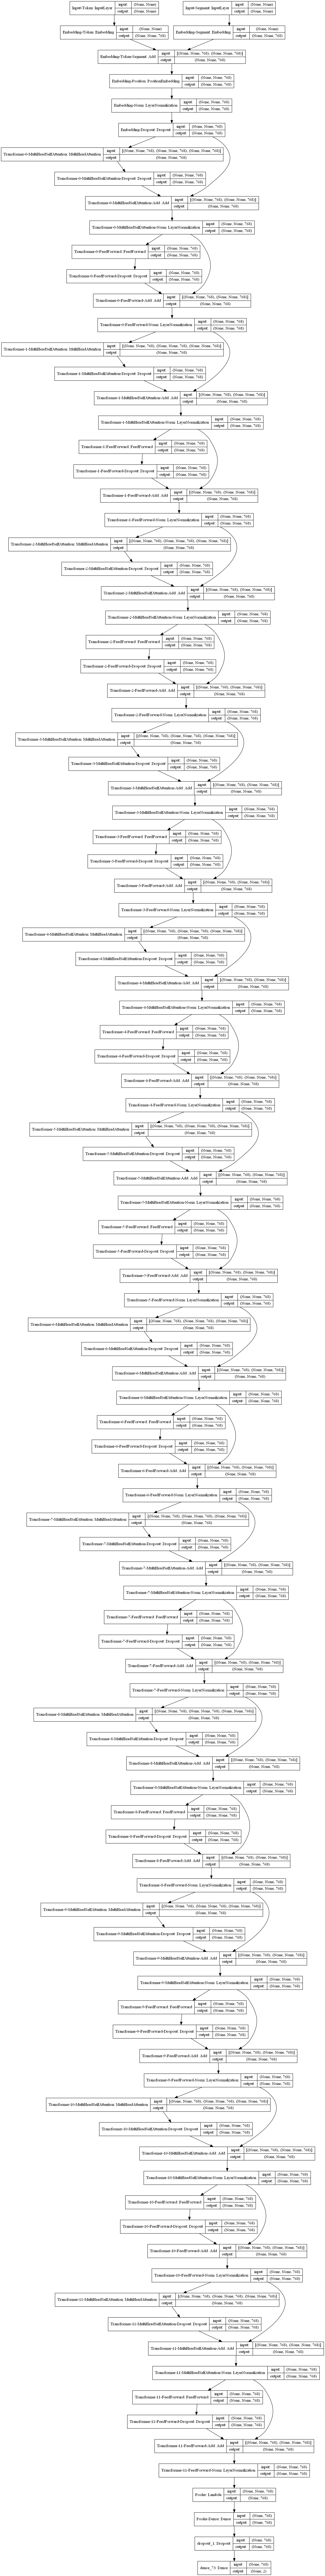

In [9]:
from keras.utils import plot_model

plot_model(model, to_file='./test_bert.png', show_shapes=True)

In [10]:
# 转换数据集
train_generator = data_generator(train_data, batch_size)
valid_generator = data_generator(valid_data, batch_size)
test_generator = data_generator(test_data, batch_size)

In [11]:
def evaluate(data):
    total, right = 0., 0.
    for x_true, y_true in data:
        y_pred = model.predict(x_true).argmax(axis=1)
        y_true = y_true[:, 0]
        total += len(y_true)
        right += (y_true == y_pred).sum()
    return right / total

In [12]:
class Evaluator(keras.callbacks.Callback):
    """评估与保存"""

    def __init__(self):
        self.best_val_acc = 0.

    def on_epoch_end(self, epoch, logs=None):
        val_acc = evaluate(valid_generator)
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            model.save_weights('best_model.weights')
        test_acc = evaluate(test_generator)
        print(
            u'val_acc: %.5f, best_val_acc: %.5f, test_acc: %.5f\n' %
            (val_acc, self.best_val_acc, test_acc)
        )

In [13]:
evaluator = Evaluator()

model.fit(
    train_generator.forfit(),
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=valid_generator.forfit(),
    validation_steps=len(valid_generator),
    callbacks=[evaluator]
)

model.load_weights('best_model.weights')
print(u'final test acc: %05f\n' % (evaluate(test_generator)))


d:\anaconda\envs\tf2.2\lib\site-packages\tensorflow\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Epoch 1/20
  4/137 [..............................] - ETA: 34:52 - loss: 1.0256 - accuracy: 0.3477

KeyboardInterrupt: 